# Birds in Iceland
__Group 4__
- Jón Björgvin Sigurðsson
- Sverrir Þór Sigurðarson
- Vignir Ómar Vignisson Löve

## Introduction

Most people pay no mind to the birds around them. Other people make checklists of every bird they see and share their findings.

In this project, we examine a subset of the [eBird Observational Dataset](https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e), that only includes birds spotted in Iceland.

For those unfamiliar with [eBird](https://ebird.org/home), it is a platform where users can share where and when they spotted certain birds. These users vary from amateur birders to professional ornithologists. The dataset also includes observations from environmental organizations.

We are going to examine both common and rare birds. We will create functions that show when bird species are likely to appear in Iceland. We will also make methods that plot the geographic location of bird species. All of these functions are highly reusable, so we encourage you to interact with the notebook. Finally, we will use machine learning to predict whether a bird is rare, based only on when it was seen and its location.

## How to use this notebook
### Imports
You might need to install some packages to run this notebook. These include, but are not limited to:
> pip install -v pandas matplotlib numpy seaborn basemap scipy imblearn sklearn plotly

In [38]:
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib.patches as mpatches
# import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy import stats
# from nltk.corpus import stopwords
from mpl_toolkits.basemap import Basemap
from IPython.display import display
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
# These two lines are needed to properly render animations in the python notebook
import plotly.io as pio
pio.renderers.default = "notebook"

### Data
In order to run this notebook, you must first extract `birds.csv` from `birds.zip` (if it hasn't already been extracted).

## Importing data
We start by reading the file to a dataframe:

In [39]:
birds = pd.read_csv("birds.csv", index_col=False)
display(birds.head())
print("Number of rows:", birds.shape[0])

vernacularName verbatimScientificName            order  \
0  Lesser Black-backed Gull           Larus fuscus  Charadriiformes   
1           Ruddy Turnstone     Arenaria interpres  Charadriiformes   
2             Glaucous Gull      Larus hyperboreus  Charadriiformes   
3           Eurasian Wigeon        Mareca penelope     Anseriformes   
4                   Mallard     Anas platyrhynchos     Anseriformes   

         family     genus specificEpithet            eventDate  year  month  \
0       Laridae     Larus          fuscus  2016-05-31T00:00:00  2016      5   
1  Scolopacidae  Arenaria       interpres  2004-09-17T00:00:00  2004      9   
2       Laridae     Larus     hyperboreus  2010-11-24T00:00:00  2010     11   
3      Anatidae      Anas        penelope  2018-06-24T00:00:00  2018      6   
4      Anatidae      Anas   platyrhynchos  2020-02-29T00:00:00  2020      2   

   day      stateProvince  decimalLatitude  decimalLongitude  individualCount  \
0   31          Suðurland        63.408356        -20.280504              1.0   
1   17           Suðurnes        64.072426        -22.660074              NaN   
2   24  Norðurland eystra        66.044800        -17.349987              NaN   
3   24          Suðurland        63.673130        -20.356092              2.0   
4   29         Vestfirðir        66.157510        -23.244152             11.0   

  iucnRedListCategory  
0                  LC  
1                  LC  
2                  LC  
3                  LC  
4                  LC

Number of rows: 751153


Most of these columns are self-explanatory but there are a couple of things we want to clear up.

`verbatimScientificName` is the [binomial name](https://en.wikipedia.org/wiki/Binomial_nomenclature) of the species. This is also the same as the columns `genus`+ `specificEpithet`. 

Regarding the [taxonomic rank](https://en.wikipedia.org/wiki/Taxonomic_rank), we only include `order`, `family`, `genus`, and `specificEpithet` and exclude `kingdom`, `phylum`, and `class`, since these fields would be identical for all records (*Animalia*, *Chordata*, and *Aves*)

The column `individualCount` says how many birds of the given species were spotted at the given time and location.

`iucnRedListCategory` is the [conservation status](https://www.iucnredlist.org/) of the species.

![](images/Status_iucn3.1.svg.png)

## Cleaning data
There are a couple of duplicated rows which we can remove:

In [40]:
print("Number of rows before:", birds.shape[0])

dupes = birds[birds.duplicated(keep=False)]
dupes = dupes.sort_values(by=["vernacularName"])
display(dupes[["vernacularName", "individualCount", "stateProvince"]].head())

birds = birds.drop_duplicates()
print("Number of rows after:", birds.shape[0])

Number of rows before: 751153


vernacularName  individualCount stateProvince
680300  Alder Flycatcher              1.0     Suðurland
212790  Alder Flycatcher              1.0      Suðurnes
176514  Alder Flycatcher              1.0      Suðurnes
489067  Alder Flycatcher              1.0      Suðurnes
498121  Alder Flycatcher              1.0      Suðurnes

Number of rows after: 655639


There are some rows where `individualCount` is NaN. We replace these values with 1.

In [41]:
print("Before")
display(birds[["vernacularName","individualCount"]].head())
birds["individualCount"] = birds["individualCount"].fillna(value=1)
print("After")
display(birds[["vernacularName","individualCount"]].head())

Before


vernacularName  individualCount
0  Lesser Black-backed Gull              1.0
1           Ruddy Turnstone              NaN
2             Glaucous Gull              NaN
3           Eurasian Wigeon              2.0
4                   Mallard             11.0

After


vernacularName  individualCount
0  Lesser Black-backed Gull              1.0
1           Ruddy Turnstone              1.0
2             Glaucous Gull              1.0
3           Eurasian Wigeon              2.0
4                   Mallard             11.0

Here we get the number of unique bird species in our dataset.

In [42]:
# Unique bird species
bird_names = birds["vernacularName"].unique().tolist()
# bird_names.sort()
# for name in bird_names:
#     print(name)

print("Number of unique bird species:", len(bird_names))

Number of unique bird species: 370


## Icelandic names and rarity
We made a `.csv` file for the species above that had the columns `vernacularName` and `verbatimScientificName`.

We added two columns to this `.csv` file: `icelandicName` and `rarity`.
The Icelandic names were manually looked up on [eBird](https://ebird.org/).

The rarity was found on a [List of Icelandic Bird Species](https://notendur.hi.is/yannk/1111.pdf) from the University of Iceland. Species with an `"F"` in the 6th column are considered rare in Iceland.

Here we import our `.csv` file:

In [43]:
bird_names_and_rarity = pd.read_csv("bird_names_and_rarity.csv", index_col=False)
# Note: We remove the verbatimScientificName column to prepare the join with the birds dataframe below
bird_names_and_rarity.drop(["verbatimScientificName"], axis=1, inplace=True)
display(bird_names_and_rarity.head())

vernacularName    icelandicName rare
0        Common Redpoll  Auðnutittlingur  NaN
1         Hoary Redpoll   Hrímtittlingur    F
2  Eurasian Sparrowhawk      Sparrhaukur    F
3    Paddyfield Warbler     Dvalsöngvari    F
4  Blyth's Reed Warbler     Elrisöngvari    F

We want the values in the `rare` column to be more descriptive so we replace `F` with `True` and `NaN` with `False`.

In [44]:
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].replace("F", True)
bird_names_and_rarity["rare"] = bird_names_and_rarity["rare"].fillna(False)
display(bird_names_and_rarity.head())

vernacularName    icelandicName   rare
0        Common Redpoll  Auðnutittlingur  False
1         Hoary Redpoll   Hrímtittlingur   True
2  Eurasian Sparrowhawk      Sparrhaukur   True
3    Paddyfield Warbler     Dvalsöngvari   True
4  Blyth's Reed Warbler     Elrisöngvari   True

We can now merge the dataframe `bird_names_and_rarity` with our main dataframe, `birds`.

In [45]:
# NOTE: Do not run this cell more than once
#       Doing so will result in multiple icelandicName and rare columns in birds
birds = pd.merge(birds, bird_names_and_rarity, how="inner", on="vernacularName")

In [46]:
birds = birds.sample(frac=1).reset_index(drop=True) # This randomly shuffles the rows, to make the output look more interesting 
display(birds.head())

vernacularName verbatimScientificName          order        family  \
0           White Wagtail         Motacilla alba  Passeriformes  Motacillidae   
1                 Mallard     Anas platyrhynchos   Anseriformes      Anatidae   
2                 Mallard     Anas platyrhynchos   Anseriformes      Anatidae   
3           White Wagtail         Motacilla alba  Passeriformes  Motacillidae   
4  Red-breasted Merganser        Mergus serrator   Anseriformes      Anatidae   

       genus specificEpithet            eventDate  year  month  day  \
0  Motacilla            alba  2012-04-23T00:00:00  2012      4   23   
1       Anas   platyrhynchos  2019-07-09T00:00:00  2019      7    9   
2       Anas   platyrhynchos  2019-07-11T00:00:00  2019      7   11   
3  Motacilla            alba  2018-07-06T00:00:00  2018      7    6   
4     Mergus        serrator  2011-10-09T00:00:00  2011     10    9   

       stateProvince  decimalLatitude  decimalLongitude  individualCount  \
0          Suðurland        64.279945        -20.359812              1.0   
1          Suðurland        64.255700        -21.124477              4.0   
2  Norðurland eystra        66.044800        -17.349987              1.0   
3          Suðurland        64.253800        -21.125916              1.0   
4           Suðurnes        63.835750        -22.450905              1.0   

  iucnRedListCategory icelandicName   rare  
0                  LC     Maríuerla  False  
1                  LC      Stokkönd  False  
2                  LC      Stokkönd  False  
3                  LC     Maríuerla  False  
4                  LC       Toppönd  False

Here we reorder the columns to put `icelandicName` in the second column. 

In [47]:
reordered_cols = [
    "vernacularName",
    "icelandicName",
    "verbatimScientificName",
    "order",
    "family",
    "genus",
    "specificEpithet",
    "eventDate",
    "year",
    "month",
    "day",
    "stateProvince",
    "decimalLatitude",
    "decimalLongitude",
    "individualCount",
    "iucnRedListCategory",
    "rare",
]
birds = birds[reordered_cols]
display(birds.head())

vernacularName icelandicName verbatimScientificName          order  \
0           White Wagtail     Maríuerla         Motacilla alba  Passeriformes   
1                 Mallard      Stokkönd     Anas platyrhynchos   Anseriformes   
2                 Mallard      Stokkönd     Anas platyrhynchos   Anseriformes   
3           White Wagtail     Maríuerla         Motacilla alba  Passeriformes   
4  Red-breasted Merganser       Toppönd        Mergus serrator   Anseriformes   

         family      genus specificEpithet            eventDate  year  month  \
0  Motacillidae  Motacilla            alba  2012-04-23T00:00:00  2012      4   
1      Anatidae       Anas   platyrhynchos  2019-07-09T00:00:00  2019      7   
2      Anatidae       Anas   platyrhynchos  2019-07-11T00:00:00  2019      7   
3  Motacillidae  Motacilla            alba  2018-07-06T00:00:00  2018      7   
4      Anatidae     Mergus        serrator  2011-10-09T00:00:00  2011     10   

   day      stateProvince  decimalLatitude  decimalLongitude  individualCount  \
0   23          Suðurland        64.279945        -20.359812              1.0   
1    9          Suðurland        64.255700        -21.124477              4.0   
2   11  Norðurland eystra        66.044800        -17.349987              1.0   
3    6          Suðurland        64.253800        -21.125916              1.0   
4    9           Suðurnes        63.835750        -22.450905              1.0   

  iucnRedListCategory   rare  
0                  LC  False  
1                  LC  False  
2                  LC  False  
3                  LC  False  
4                  LC  False

Here we can see the proportion of rare birds in our database.

In [48]:
print("Proportion of records where the bird is rare.")
rarities = (birds["rare"]).value_counts(normalize=True) * 100
print("Rare:        {0:.2f}%".format(rarities[1]))
print("Not rare:    {0:.2f}%".format(rarities[0]))

Proportion of records where the bird is rare.
Rare:        3.22%
Not rare:    96.78%


We can also see the proportion of records by conservation status.

In [49]:
print("Proportion of records by conservation status.")
redList = (birds["iucnRedListCategory"]).value_counts(normalize=True) * 100

print("Least Concern (LC):          {0:>2f}%".format(redList[0]))
print("Near Threatened (NT):        {0:>2f}%".format(redList[1]))
print("Vulnerable (VU):             {0:>2f}%".format(redList[2]))
print("Not Evaluated (NE):          {0:>2f}%".format(redList[3]))
print("Critically Endangered (CR):  {0:>2f}%".format(redList[4]))

Proportion of records by conservation status.
Least Concern (LC):          80.004088%
Near Threatened (NT):        11.986017%
Vulnerable (VU):             4.503850%
Not Evaluated (NE):          3.505893%
Critically Endangered (CR):  0.000153%


The calculations above do not account for the number of _individual_ birds counted in each occurrence. We can adjust this by including `individualCount` in our calculation. 

The function `proportional_sightings()` can be used to address this.

In [50]:
def proportional_sightings(frame:pd.DataFrame, scope_constraints:dict, search_params:dict):
	"""Returns the proportion of search_params in scope_constraints

	Parameters
	----------
	frame : pd.DataFrame
		The dataframe to search
	scope_constraints : dict
		The constraints to apply to the scope of the search
	search_params : dict
		The parameters to search for
	
	Returns
	-------
	float
		The proportion of search_params in scope_constraints

	Example
	-------
	proportional_sightings(birds, {"stateProvince":"Iceland"}, {"stateProvince":"Iceland", "rare":True})
	"""
	all_sightings = frame
	for constraint in scope_constraints:
		all_sightings = all_sightings.loc[all_sightings[constraint] == scope_constraints[constraint]]
	all_sum = all_sightings["individualCount"].sum()
	search_sightings = all_sightings
	for constraint in search_params:
		search_sightings = search_sightings.loc[search_sightings[constraint] == search_params[constraint]]
	search_sum = search_sightings["individualCount"].sum()
	proportion = search_sum / all_sum
	return proportion

Here is the adjusted proportion of rare birds.

In [51]:
scope_constraints = {}
search_params = {"rare": True}
rare = proportional_sightings(birds, scope_constraints, search_params)
search_params = {"rare": False}
not_rare = proportional_sightings(birds, scope_constraints, search_params)
print("Proportion of rare individuals counted:")
print("Rare:        {0:.2f}%".format(rare))
print("Not rare:    {0:.2f}%".format(not_rare))

Proportion of rare individuals counted:
Rare:        0.00%
Not rare:    1.00%


This is the adjusted proportion of birds by conservation status.

In [52]:
iucnList = ["LC", "NT", "VU", "NE", "CR"]
iucnProp = []
scope_constraints = {}
for cat in iucnList:
    search_params = {"iucnRedListCategory": cat}
    p = proportional_sightings(birds, scope_constraints, search_params)
    iucnProp.append(p)

print("Proportion of individuals counted by conservation status")
print("Least Concern (LC):          {0:>2f}%".format(iucnProp[0]))
print("Near Threatened (NT):        {0:>2f}%".format(iucnProp[1]))
print("Vulnerable (VU):             {0:>2f}%".format(iucnProp[2]))
print("Not Evaluated (NE):          {0:>2f}%".format(iucnProp[3]))
print("Critically Endangered (CR):  {0:>2f}%".format(iucnProp[4]))

Proportion of individuals counted by conservation status
Least Concern (LC):          0.611162%
Near Threatened (NT):        0.166902%
Vulnerable (VU):             0.177768%
Not Evaluated (NE):          0.044167%
Critically Endangered (CR):  0.000000%


## Overview of the data

Let's take a look at how our data is distributed. We'll start by looking at the total number of birds counted per year.

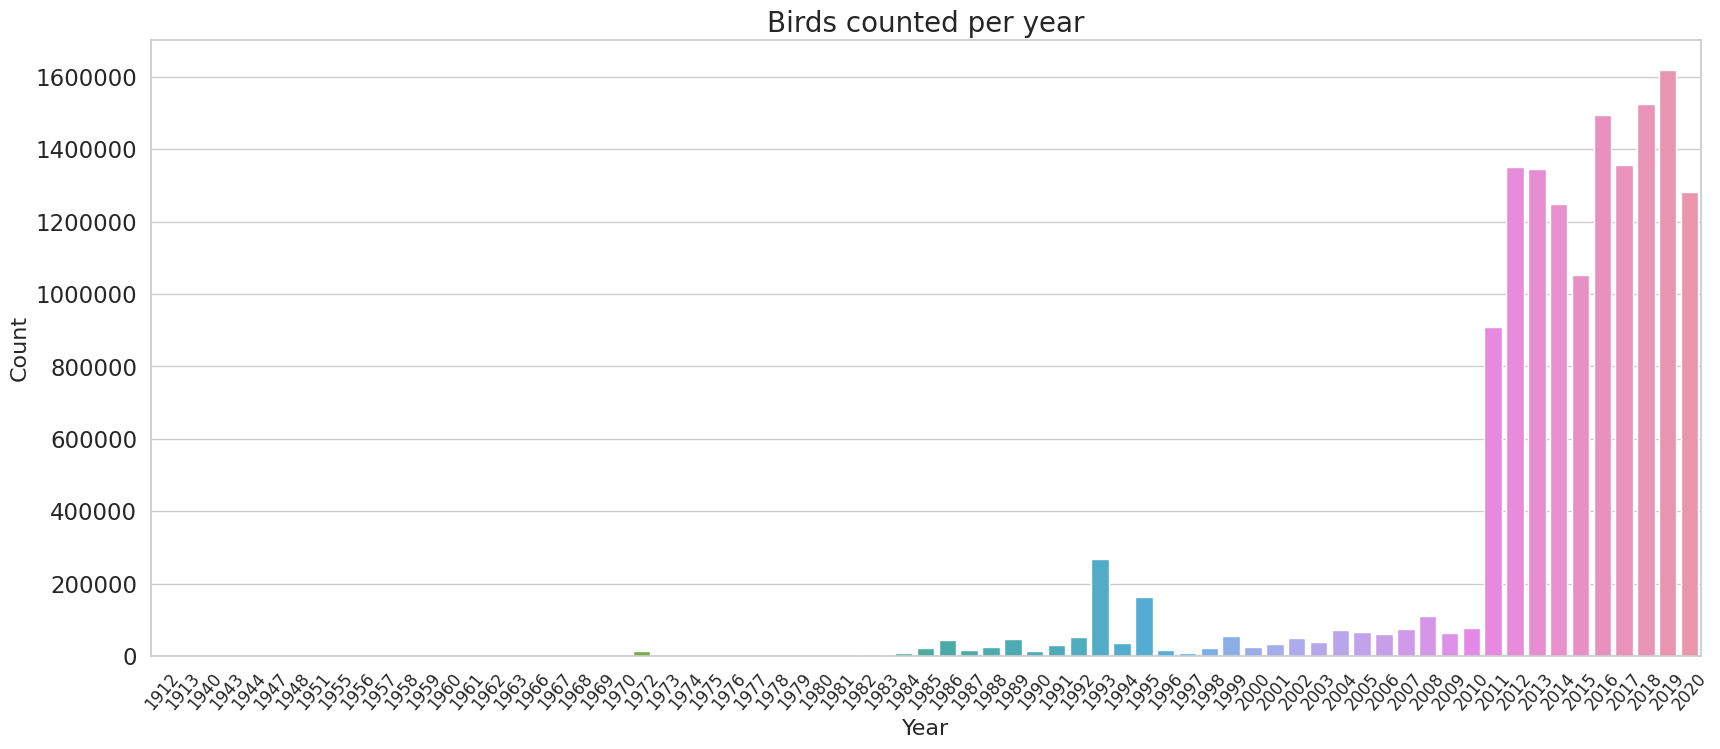

In [53]:
y = birds.groupby(['year']).sum()
y = y['individualCount']
x = y.index.astype(int)

plt.figure(figsize=(20,8))
ax = sns.barplot(y = y, x = x)
ax.set_xlabel(xlabel='Year', fontsize=16)
ax.set_xticklabels(labels = x, fontsize=12, rotation=50)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.ticklabel_format(style='plain', axis='y')
ax.set_title(label='Birds counted per year', fontsize=20)
plt.show()

We can also examine this data on by month.

In [54]:
def make_heatmap(frame, year_start=1900):
    """
    Creates a heatmap of the number of birds counted per month and year.

    Parameters
    ----------
    frame : pandas DataFrame
        The DataFrame to use for the heatmap.
    year_start : int, optional
        The year to start counting from. Defaults to 1900.
    """
    frame = frame[(frame["year"] >= year_start)]
    heatmap_prep = frame.pivot_table(
        index=frame["year"],
        columns=frame["month"],
        values="individualCount",
        aggfunc=np.sum,
    )
    return sns.heatmap(heatmap_prep, cmap="Reds")

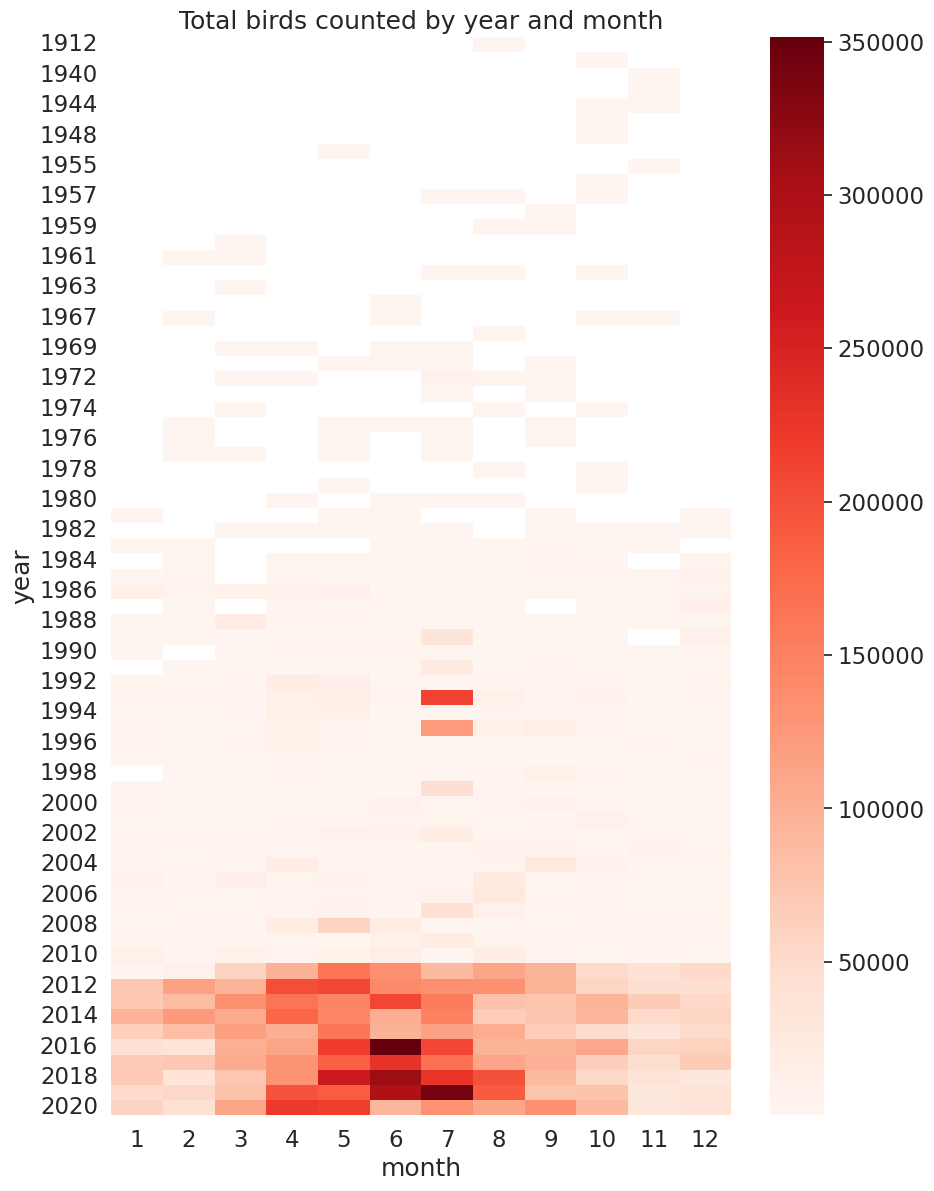

In [55]:
fig, ax = plt.subplots(figsize=(10, 14))
ax = make_heatmap(birds)
plt.title("Total birds counted by year and month")
plt.show()

Note the increase in records starting in 2011. While the eBird platform was launched in 2002, it was initially restricted to the Americas. In 2010 eBird expanded to cover the whole world. In all likelihood, this is the reason for the massive increase in data.

The nature of the data also changes over time. Rare birds account for a significant share of the 20th-century records. These are usually cases of rare vagrant birds that were sent to the Icelandic Rarities Committee (Flækingsfuglanefnd). We plot the percentage of rare birds per year below.

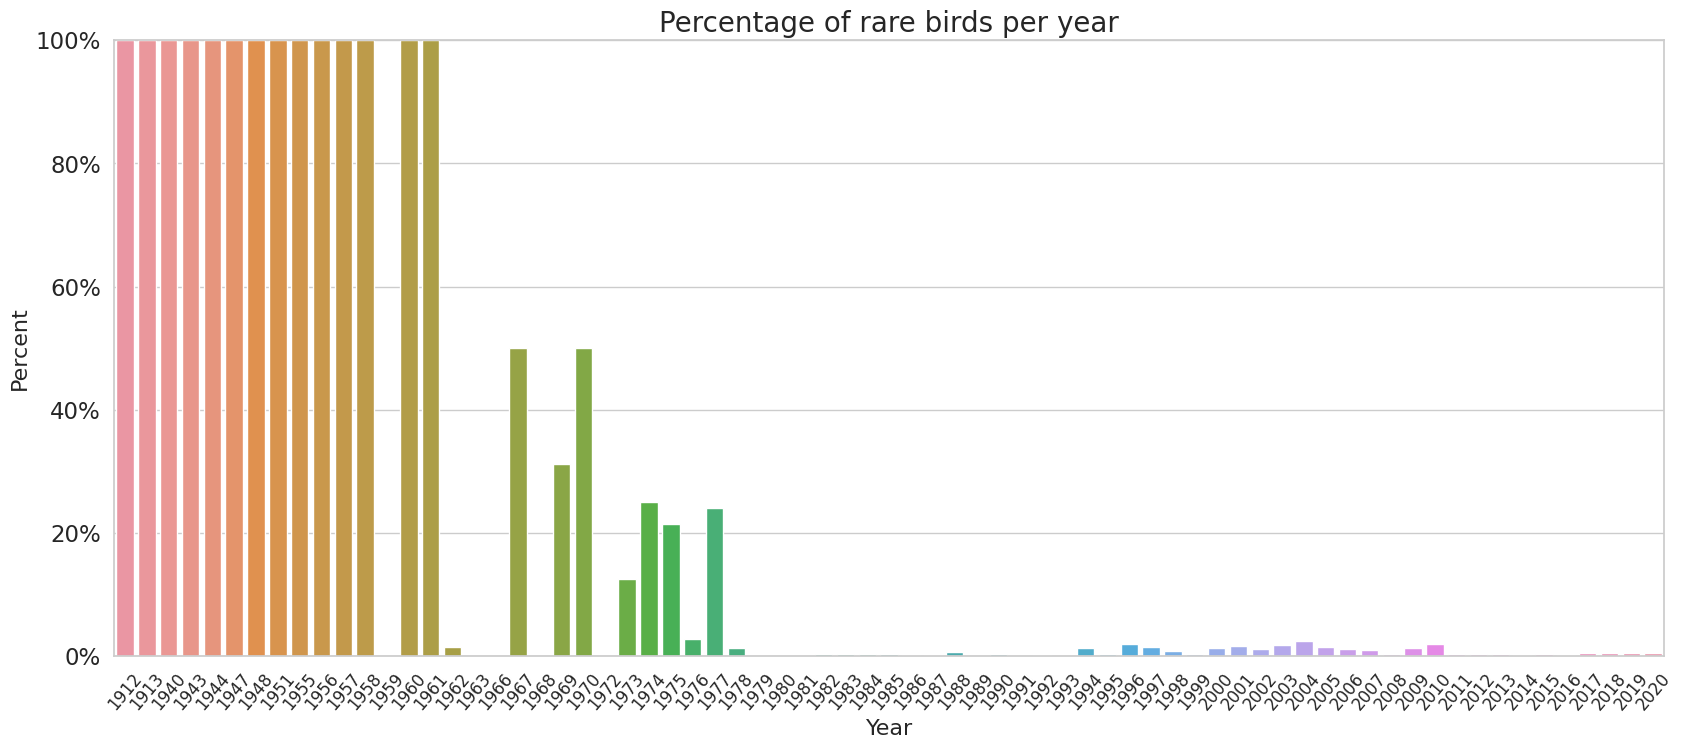

In [56]:
years = birds["year"].unique().tolist()
years.sort()
year_rares = pd.DataFrame(columns=["year", "rareProp"])
for y in years:
    scope_constraints = {"year": y}
    search_params = {"rare": True}
    p = proportional_sightings(birds, scope_constraints, search_params)
    # iucnProp.append(p)
    # print(y, p)
    year_rares.loc[len(year_rares.index)] = [y, (p * 100)]

year_rares.year = year_rares.year.astype("int")
plt.figure(figsize=(20,8))
ax = sns.barplot(y = year_rares.rareProp, x = year_rares.year)
ax.set_xlabel(xlabel='Year', fontsize=16)
ax.set_xticklabels(labels = x, fontsize=12, rotation=50)
ax.set_ylabel(ylabel='Percent', fontsize=16)
ax.set_title(label='Percentage of rare birds per year', fontsize=20)
ax.set(ylim=(0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

These are the top 30 most "common" rare species:

In [57]:
rarebirds = birds[birds["rare"] == True]
rares = rarebirds["vernacularName"].value_counts()
rares = rares.to_frame(name="# counted")
rares.head(30)

# counted
Goldcrest                   2400
Eurasian Blackcap           1219
Common Shelduck             1189
Northern Shoveler           1119
King Eider                  1118
Gray Heron                  1000
Bohemian Waxwing             987
Brambling                    714
Common Goldeneye             590
European Robin               576
Red Crossbill                566
Eurasian Curlew              546
Common Chiffchaff            460
American Wigeon              369
Barn Swallow                 355
Hoary Redpoll                335
Common Chaffinch             323
Little Gull                  289
Yellow-browed Warbler        256
Willow Warbler               250
Eurasian Coot                191
Ring-necked Duck             185
Common Wood-Pigeon           179
Eurasian Siskin              178
Song Thrush                  164
Canada Goose                 156
Common Pochard               141
Ring-billed Gull             139
Northern Lapwing             139
Lapland Longspur             139

These are the 30 most rare bird species encountered:

In [58]:
rares.tail(30)

# counted
Eastern Olivaceous Warbler            2
Carrion Crow                          1
Scarlet Tanager                       1
Cedar Waxwing                         1
Subalpine Warbler                     1
Acadian Flycatcher                    1
Least Flycatcher                      1
Pechora Pipit                         1
Black Stork                           1
Fox Sparrow                           1
Crested Auklet                        1
Red Kite                              1
Canada Warbler                        1
Pine Bunting                          1
Ruby-crowned Kinglet                  1
Palm Warbler                          1
Eurasian Tree Sparrow                 1
Squacco Heron                         1
Wood Thrush                           1
White Stork                           1
Slaty-backed Gull                     1
Common Buzzard                        1
Tawny Pipit                           1
Black-and-white Warbler               1
Pacific Swift                         1
Siberian Rubythroat                   1
Dark-eyed Junco                       1
Black-throated Green Warbler          1
Yellow-breasted Bunting               1
Red-breasted Nuthatch                 1

## Examining bird species

Now we are going to look at data related to specific bird species.

#### European Golden Plover
![European Golden Plover - Author: Jerzy Strzelecki](images/European_Golden_Plover.jpg)

In Icelandic folklore, the appearance of the first plover in the country means that spring has arrived.

Here pick the first European Golden Plover record for each year to find out in which month it is most likely to arrive.

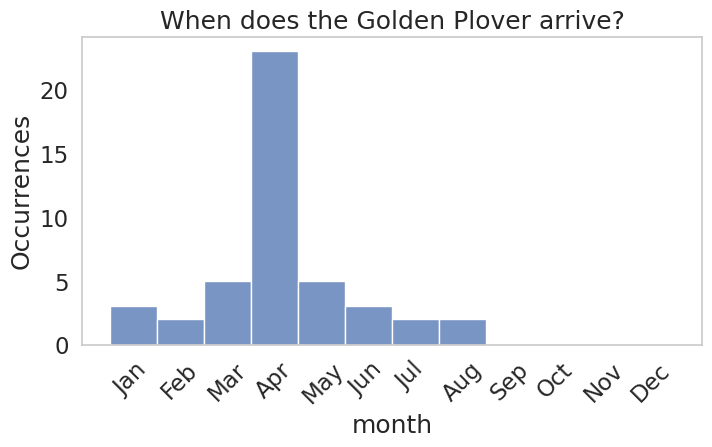

In [59]:
plovers = birds[birds["vernacularName"] == "European Golden-Plover"]
plovers = plovers[["vernacularName", "year", "month", "day"]]
plovers = plovers.sort_values(by=["year", "month", "day"])

first_plovers = plovers.drop_duplicates(
    subset=["year"], keep="first"
)  # Keep only the first record in each year
first_plovers = first_plovers[["vernacularName", "year", "month", "day"]]
first_plovers = first_plovers.reset_index(drop=True)

# Set up histogram plot
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.arange(1, 14)
sns.histplot(first_plovers["month"], bins=bins)
ax.set_xticks(bins[:-1])
ax.set_xticklabels([dt.date(1900, i, 1).strftime("%b") for i in bins[:-1]], rotation=45, ha="left")
ax.set_title("When does the Golden Plover arrive?")
ax.set_ylabel("Occurrences")
ax.grid(False)
plt.show()

### Drawing maps
Since we are gonna be plotting multiple maps we define a function `make_map()` to draw a map of Iceland.

In [60]:
# Function that returns a Basemap of Iceland
def make_map():
    plt.subplots(figsize=(16, 32))
    # Map setup
    m = Basemap(
        resolution="i",  # Resolution
        projection="merc",  # Mercator projection
        llcrnrlon=-25.33,
        llcrnrlat=63.2,
        urcrnrlon=-12.8,
        urcrnrlat=66.66,
        # lat_0 = 64.71327322667472,
        # lon_0 = -18.311514290548956
    )
    land_color = "forestgreen"
    ocean_color = "paleturquoise"
    m.drawcoastlines()
    m.fillcontinents(color=land_color, lake_color=ocean_color)
    m.drawmapboundary(fill_color=ocean_color)
    # m.drawrivers() # Not sure if we want to draw rivers or not
    return m

We also define a function to plot the location of birds on our map.

In [61]:
def plot_birds(frame, map, marker="ro", alpha_level=1, z=1):
    """ Plots birds on a Basemap
    Parameters
    ----------
    frame : pandas DataFrame
        DataFrame containing bird data
    map : Basemap
        Basemap object
    marker : str
        Marker for the data point (defaults to "ro", red dot)
    alpha_level : float
        Controls transparency of the marker (defaults to 1)
    z : int
        Controls z-order (defaults to 1)
    """

    def plot_coords(row, map):
        lon = row["decimalLongitude"]
        lat = row["decimalLatitude"]
        # TODO: Figure out how to make the size work correctly.
        #       Some of the individual counts are very high,
        #       leading to ridiculously large markers
        size = np.sqrt(row["individualCount"] * 10)
        x, y = map(lon, lat)
        map.plot(
            x, y, marker, alpha=alpha_level, markersize=size, zorder=z
        )

    # Iterate over the dataframe and plot coordinates
    for index, row in frame.iterrows():
        plot_coords(row, map)

#### White-tailed Eagle
![White-tailed eagle - Author: Jacob Spinks](images/White-tailed_Eagle.jpg)


Now we can easily plot the location of birds on our map. If we want to know the location of [White-tailed Eagles](https://ebird.org/species/whteag) we can do so like this:

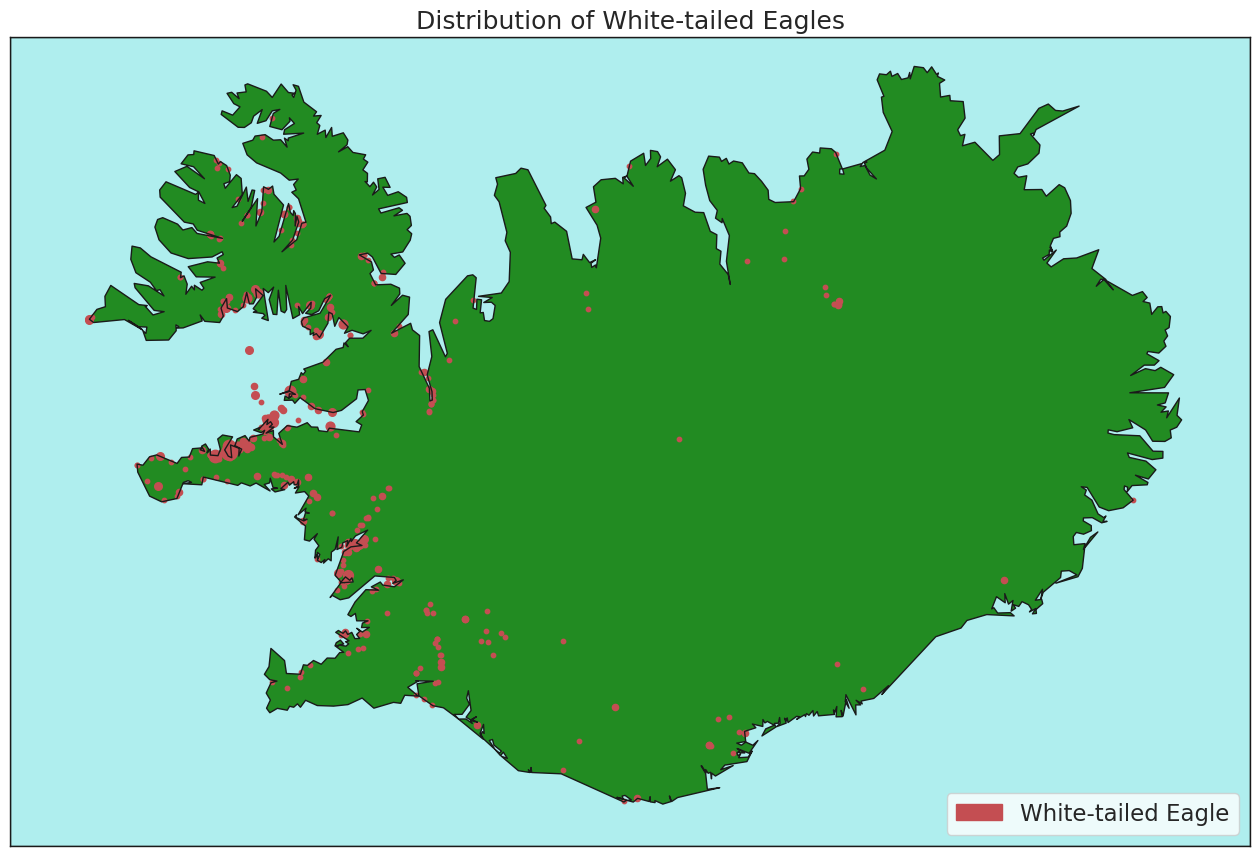

In [62]:
# First, we make a seperate dataframe that only contains the White-Tailed Eagles (Ísl: Haförn)
eagles = birds[birds["vernacularName"] == "White-tailed Eagle"]
# Second, we make a map by calling our helper function, make_map()
map = make_map()
# Third, we plot the location of the Eagles on our map by using plot_birds()
plot_birds(eagles, map)
eagle_patch = mpatches.Patch(color="r", label="White-tailed Eagle")
plt.legend(handles=[eagle_patch], loc="lower right")
plt.title("Distribution of White-tailed Eagles")
plt.show()

### Plotting multiple species

#### Northern Fulmar and Common Eider
![Northern Fulmar - Author: Avenue](images/Northern_Fulmar.jpg) ![Common Eider - Author: Ryan Hodnett](images/Common_Eider.jpg)

We can also plot the location of multiple different species. Here we are going to compare the locations of [White-tailed Eagles](https://ebird.org/species/whteag), and two other species it preys upon: [Northern Fulmars](https://ebird.org/species/norful), and [Common Eiders](https://ebird.org/species/comeid), to check if their distribution overlaps.

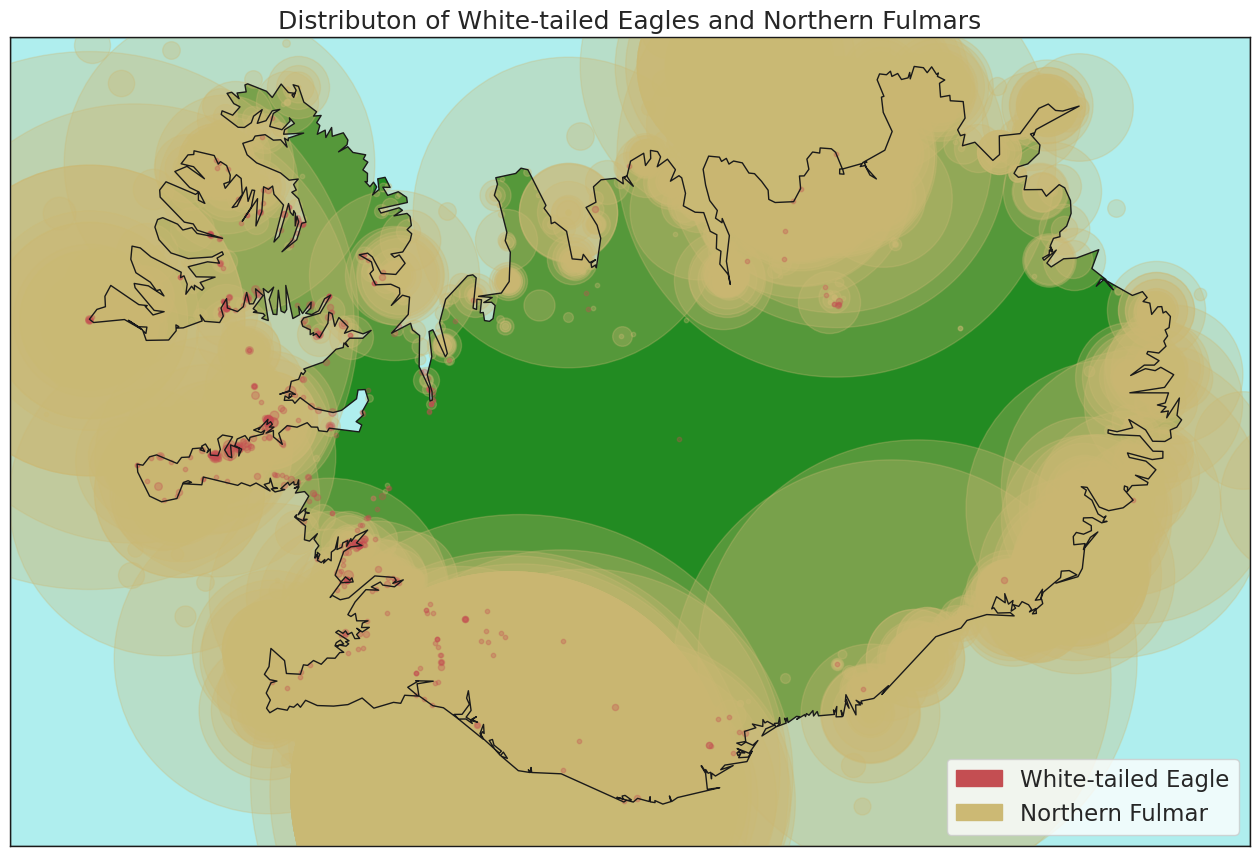

In [63]:
fulmars = birds[birds["vernacularName"] == "Northern Fulmar"] # Ísl: Fýll

map = make_map()

# Here we set the alpha level to 0.3 to deal with overlapping markers
plot_birds(fulmars, map, "yo", 0.3)
plot_birds(eagles, map, "ro", 0.3)
fulmar_patch = mpatches.Patch(color="y", label="Northern Fulmar")
eider_patch = mpatches.Patch(color="b", label="Common Eider")
plt.legend(handles=[eagle_patch, fulmar_patch], loc="lower right")
plt.title("Distributon of White-tailed Eagles and Northern Fulmars")
plt.show()

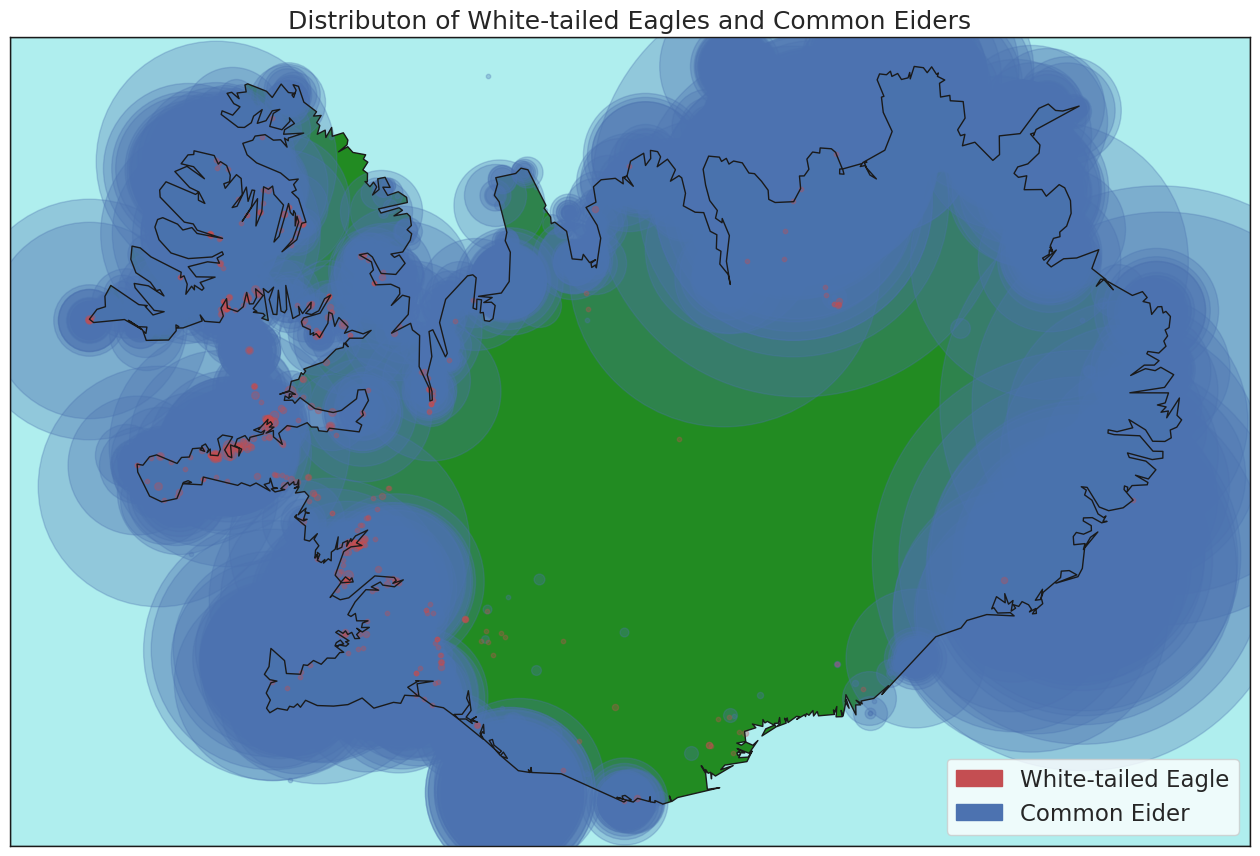

In [64]:
eiders = birds[birds["vernacularName"] == "Common Eider"] # Ísl: Æðarfugl

map = make_map()

# Here we set the alpha level to 0.3 to deal with overlapping markers
plot_birds(eiders, map, "bo", 0.3)
plot_birds(eagles, map, "ro", 0.3)
eider_patch = mpatches.Patch(color="b", label="Common Eider")
plt.legend(handles=[eagle_patch, eider_patch], loc="lower right")
plt.title("Distributon of White-tailed Eagles and Common Eiders")
plt.show()

Based on the figures above we can observe that the White-tailed Eagle is mostly spotted in areas that are densely populated by both Northern Fulmars and Common Eiders.

#### Whooper Swan
![Whooper Swan - Author: Joachim Kohler](images/Whooper_Swan.jpg)

There are three fjords in Iceland named Álftafjörður (Swan Fjord) after the [Whooper Swan](https://ebird.org/species/whoswa). We are going to see if they live up to their name.

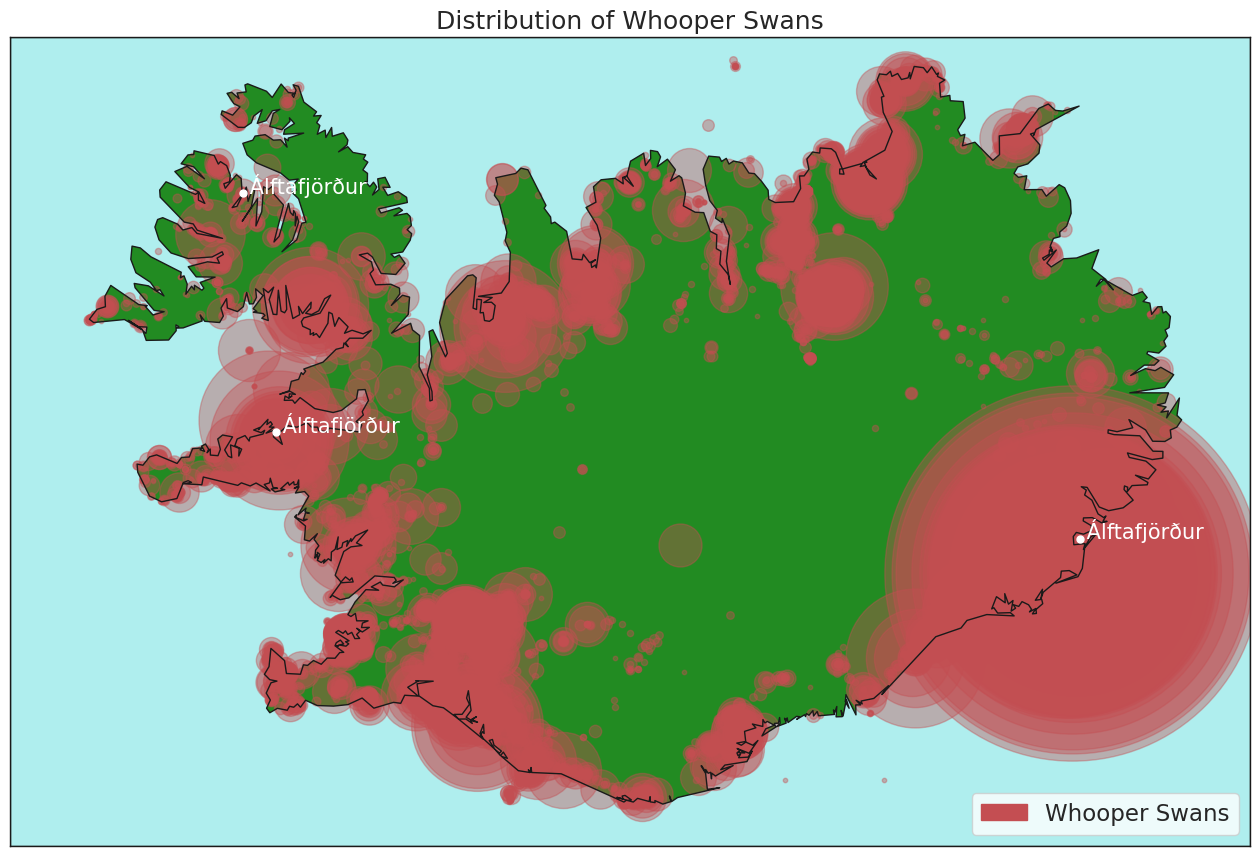

In [65]:
swans = birds[birds["vernacularName"] == "Whooper Swan"] # Ísl: Álft/Svanur

map = make_map()

plot_birds(swans, map, alpha_level=0.4)
fjords = [
    (64.567333, -14.515770),
    (65.026056, -22.646270),
    (66.025078, -22.970722),
]
for f in fjords:
    lon, lat = f
    x, y = map(lat, lon)
    map.plot(x, y, 'ok', markersize=5, color='w', zorder=3)
    plt.text(x, y, ' Álftafjörður', fontsize=15, color='w', zorder=3)
swan_patch = mpatches.Patch(color="r", label="Whooper Swans")
plt.legend(handles=[swan_patch], loc="lower right")
plt.title("Distribution of Whooper Swans")
plt.show()

Based on the figure above we can see that at least two of the fjords deserve their name.

## Migration and seasonal differences

Bird occurrences are not spread out uniformly through time. The birds you might see in January will most likely differ from the birds you will see in July. 

Many bird species are migratory. Some of them come to Iceland to breed in the summer months, while others choose Iceland as their wintering site.

In this section, we will explore how these patterns of bird occurrences change throughout time.

#### Atlantic Puffin
![Atlantic Puffin - Author: Richard Bartz](images/Atlantic_Puffin.jpg)

The [Atlantic Puffin](https://ebird.org/species/atlpuf) is by far the most common bird in Iceland with an estimated 2.000.000 breeding pairs and a total of around 7.000.000 birds by autumn.

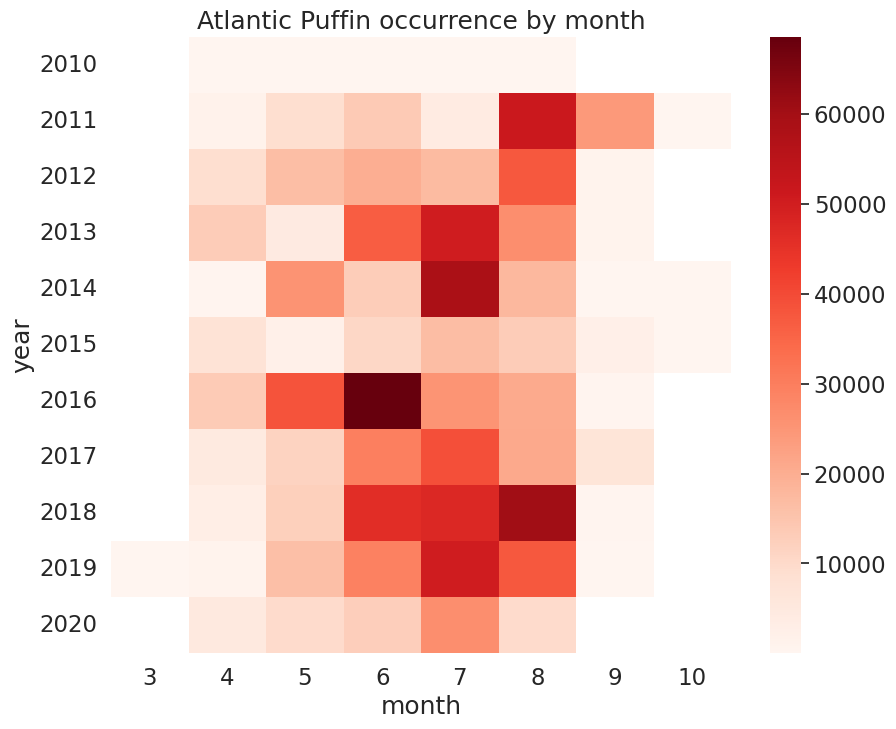

In [66]:
puffins = birds[birds["vernacularName"] == "Atlantic Puffin"] # Ísl: Lundi
puffins.head()
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(puffins, 2010)
plt.title("Atlantic Puffin occurrence by month")
plt.show()

Note how, despite having such a huge population, the puffins seem to appear out of thin air at the end of spring and completely disappear by the start of autumn.

The reason for this is simple. Atlantic Puffins spend the majority of their life far out on the northern seas. They only return to land to breed.

#### Arctic Tern
![Arctic Tern - Author: Andreas Weith](images/Arctic_Tern.jpg)

[Arctic Terns](https://ebird.org/species/arcter) are very commonly seen in Iceland during the summer.

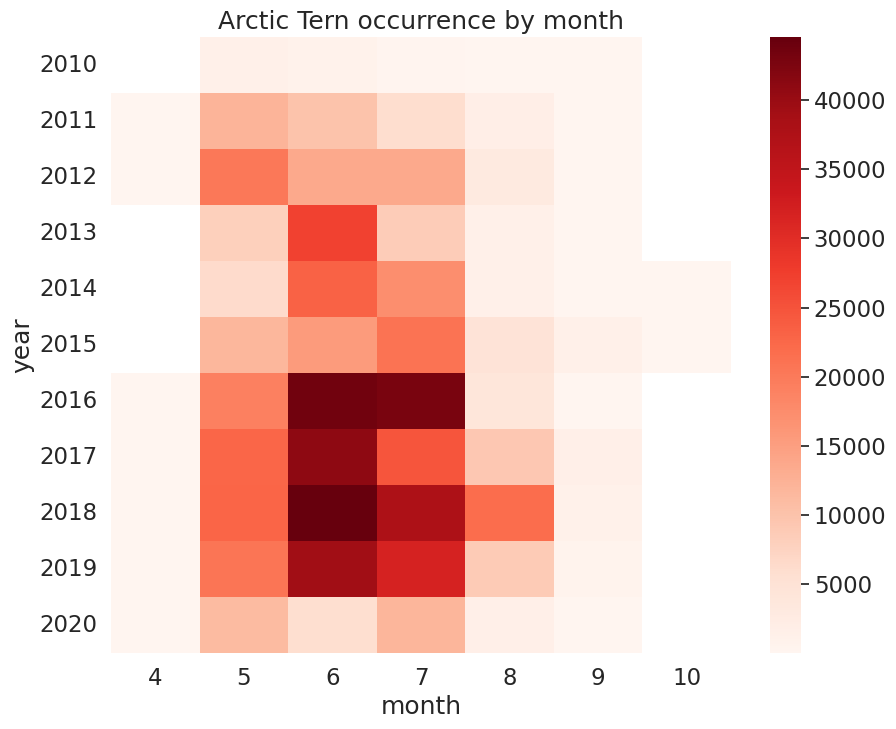

In [67]:
terns = birds[birds["vernacularName"] == "Arctic Tern"] # Ísl: Kría
terns.head()
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(terns, 2010)
plt.title("Arctic Tern occurrence by month")
plt.show()

These terns migrate all the way from Antarctica to their breeding grounds in Iceland and back again each year. Their migratory journey is the longest in the animal kingdom, with an average annual round-trip length of about 70,900 km. This allows them to experience two summers; one in the Southern Hemisphere and another in the Northern Hemisphere.

#### Gray Heron
![Gray Heron - Author: Basile Morin](images/Gray_Heron.jpg)

The [Gray Heron](https://ebird.org/species/graher1) is not endemic to Iceland and is considered [rare](#icelandic-names-and-rarity).

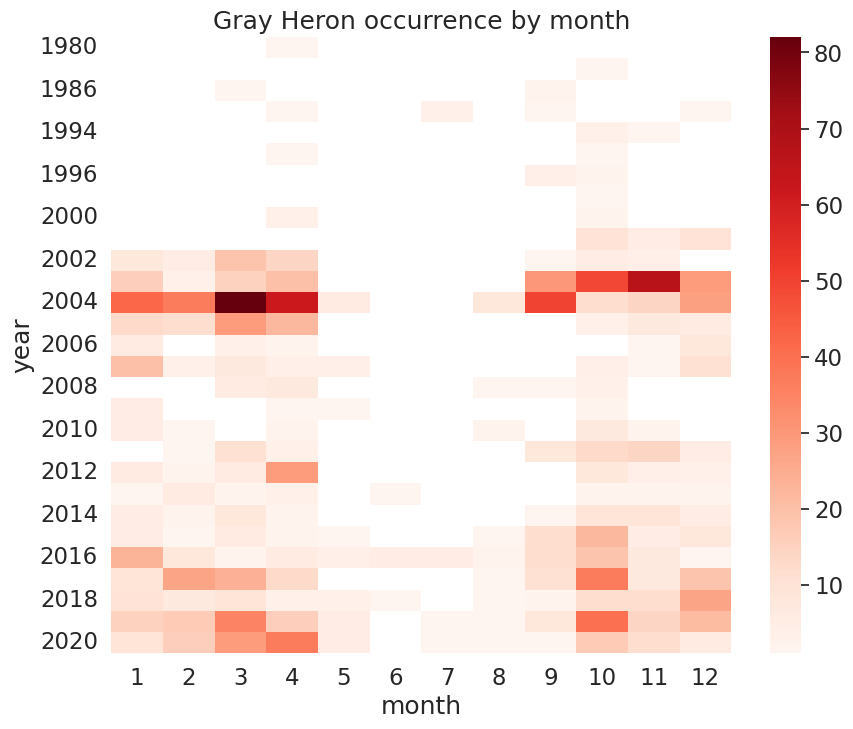

In [68]:
grayHerons = birds[birds["vernacularName"] == "Gray Heron"]
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(grayHerons)
plt.title("Gray Heron occurrence by month")
plt.show()

Here we see an inverse of the occurrence patterns we saw with the Atlantic Puffins and Arctic Terns. It seems that the Gray Heron is (mostly) a winter vagrant in Iceland.

#### Goldcrest
![Goldcrest - Author: Francis C. Franklin](images/Goldcrest.jpg)

We can use our heatmap function to examine the overall population and breeding status of a species.

[Goldcrests](https://ebird.org/species/goldcr1) are the smallest European birds. They used to be rare vagrants in Iceland but in the last two and a half decades they have colonized the country and are now considered resident birds.

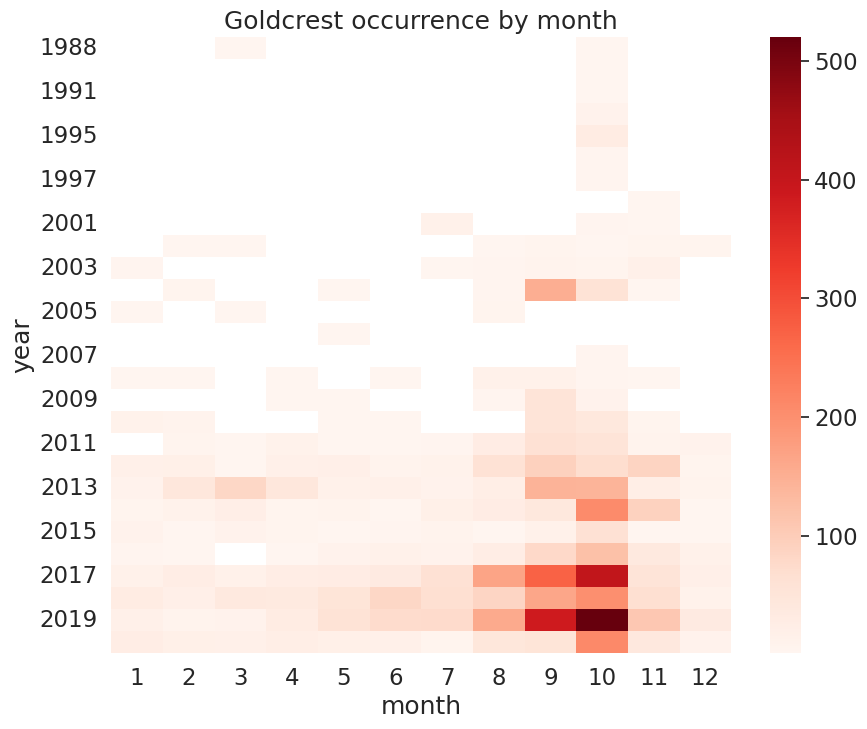

In [69]:
goldcrests = birds[birds["vernacularName"] == "Goldcrest"]
fig, ax = plt.subplots(figsize=(10, 8))
ax = make_heatmap(goldcrests)
plt.title("Goldcrest occurrence by month")
plt.show()

This confirms what has been written about the goldcrest population in Iceland. Goldcrests started appearing in large numbers around 1995 and breeding was confirmed in 1999 (*Róbert Arnar Stefánsson and Sigrún Bjarnadóttir*). The population crashed in the autumn of 2005 but has since bounced back. (*Kristinn Haukur Skarphéðinsson*).

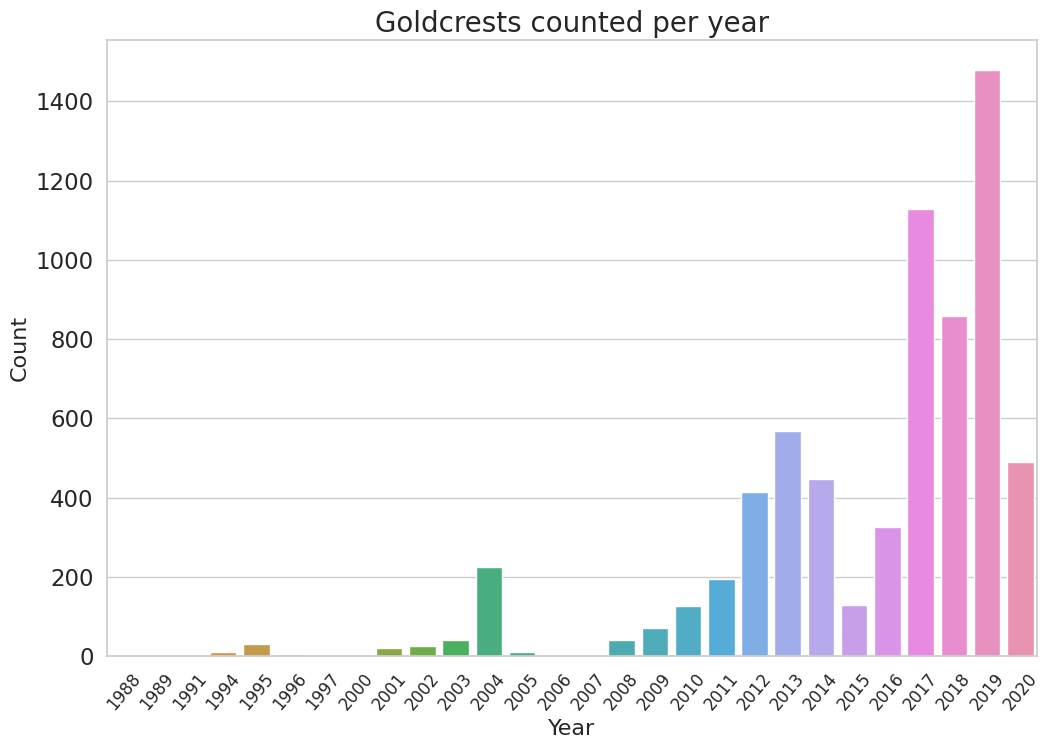

In [70]:
y = goldcrests.groupby(['year']).sum()
y = y['individualCount']
x = y.index.astype(int)

plt.figure(figsize=(12,8))
ax = sns.barplot(y = y, x = x)
ax.set_xlabel(xlabel='Year', fontsize=16)
ax.set_xticklabels(labels = x, fontsize=12, rotation=50)
ax.set_ylabel(ylabel='Count', fontsize=16)
ax.set_title(label='Goldcrests counted per year', fontsize=20)
plt.show()

### Geographical heatmaps

We were interested in seeing the areas where birds tend to flock to throughout the year. In order to do so we make a new function, `monthly_plot()`:

In [71]:
def monthly_plot(dataframe: pd.DataFrame, img="", style="stamen-terrain"):
    """
    Plots an animation of geographic density heatmaps
    of a given species throughout the year.
    The dataframe should already be filtered down to
    a single species for this to make sense.

    Parameters
    ----------
    dataframe : pandas DataFrame
        A dataframe containing the data for a single species
    img : str, optional
        A path to an image to use as the background, by default ""
    style : str, optional
        The mapbox style to use, by default "stamen-terrain"
    """
    dataframe = dataframe.sort_values(by=["month", "day"])
    highest = dataframe["individualCount"].max()
    bird_name = dataframe["vernacularName"].iloc[0]
    fig = px.density_mapbox(
        dataframe,
        lat=dataframe["decimalLatitude"],
        lon=dataframe["decimalLongitude"],
        z=dataframe["individualCount"],
        zoom=5,
        title=bird_name + " occurrence by month",
        mapbox_style=style,
        animation_frame=dataframe["month"],
        range_color=(1, highest),
    )

    fig.update_layout(
        autosize=False, width=900, height=800, coloraxis_colorbar_title_text="Count"
    )
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 1000
    fig.layout.coloraxis.showscale = True
    fig.layout.sliders[0].pad.t = 10
    fig.layout.updatemenus[0].pad.t = 10
    bird_name = bird_name.replace(" ", "_")
    # fig.write_html("./animations/" + bird_name + ".html")
    if img != "":
        fig.add_layout_image(
            dict(
                source=img,
                xref="paper",
                yref="paper",
                x=1,
                y=1,
                sizex=0.2,
                sizey=0.2,
                xanchor="right",
                yanchor="bottom",
            )
        )
    fig.show()

We can test this using some of our previously defined dataframes.

__Important note:__ if you are viewing this notebook (`Birds.ipynb`) on github, the plots below might not get rendered. If this is the case you can view it on [nbviewer.org](https://nbviewer.org/github/sveppalicious/Birds/blob/main/Birds.ipynb?flush_cache=True). You can also download the file `Birds.html` on github and view it in your browser.

#### Atlantic Puffin - monthly distribution

In [72]:
# See note above if this cell does not get rendered for you.
monthly_plot(puffins, "images/Atlantic_Puffin.jpg")

### Arctic Tern - monthly distribution

In [73]:
# See note above if this cell does not render for you
monthly_plot(terns, "images/Arctic_Tern.jpg")

### Whooper Swan - monthly distribution

In [74]:
# See note above if this cell does not render for you
monthly_plot(swans, "images/Whooper_Swan.jpg")

## Statistical tests

Here we want to compare the number of individuals counted for three different species: [White-tailed Eagles](https://ebird.org/species/whteag), [Northern Fulmars](https://ebird.org/species/norful), and [Common Eiders](https://ebird.org/species/comeid).

The White-tailed Eagle heavily preys upon these two species so we want to see if the population sizes affect each other.

Due to the imbalance of our data, we are not going to count records before 2010.

We start by looking at the probability distribution of `individualCount`:

Bootstrap mean: 23.161631091
95% confidence interval lies between  [21.9562265]  and  [24.474473]


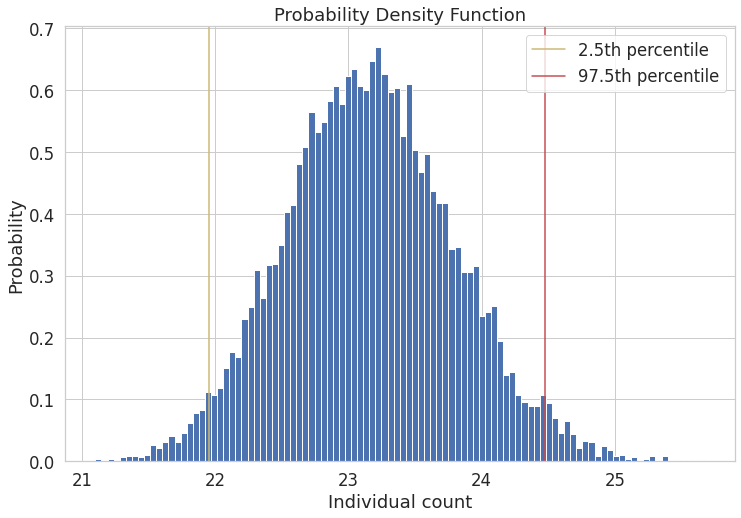

In [38]:
c_data = birds.drop(birds[birds.year < 2010].index) # Take current data by dropping records before 2010
# Take a sample of 100000 individual counts
samp = c_data["individualCount"].sample(100000).reset_index(drop=True)
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

boots = draw_bs_replicates(samp, np.mean, 10000)
lower = str(np.percentile(boots,[2.5]))
upper = str(np.percentile(boots,[97.5]))

# Print the mean of bootstrap replicates
print("Bootstrap mean: " + str(np.mean(boots)))
print("95% confidence interval lies between ", lower, " and ", upper)
plt.figure(figsize=(12,8))
plt.hist(boots,bins=100,density=True)

# Showing the related percentiles
plt.axvline(x=np.percentile(boots,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(boots,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.xlabel("Individual count")
plt.ylabel("Probability")
plt.title("Probability Density Function")
plt.legend()
plt.show()

We proceed by putting the three species in individual dataframes containing `year` and `individualCount`.

In [39]:
white_tailed_eagle = c_data.loc[c_data['vernacularName'] == 'White-tailed Eagle'][['year', 'individualCount']]
fulmar = c_data.loc[c_data['vernacularName'] == 'Northern Fulmar'][['year', 'individualCount']]
eider = c_data.loc[c_data['vernacularName'] == 'Common Eider'][['year', 'individualCount']]

white_tailed_eagle = white_tailed_eagle.groupby(by=['year']).sum()
fulmar = fulmar.groupby(by=['year']).sum()
eider = eider.groupby(by=['year']).sum()

Here we perform an ANOVA on the three dataframes.

In [40]:
fvalue, pvalue = stats.f_oneway(white_tailed_eagle, fulmar, eider)
print("p-value:", pvalue)

p-value: [1.95918644e-07]


Here we perform Kruskal–Wallis H test on the three dataframes.

In [41]:
fvalue, pvalue = stats.kruskal(white_tailed_eagle, fulmar, eider)
print("p-value:", pvalue)

p-value: [1.46165866e-05]


Here we perform a T-test on `White-tailed Eagles` and `Northern Fulmars`.

In [42]:
res = stats.ttest_ind(white_tailed_eagle,
                      fulmar,
                      equal_var=False)
print("p-value:", res.pvalue)

p-value: [7.11873005e-05]


Here we perform a T-test on `White-tailed Eagles` and `Common Eiders`.

In [43]:
res = stats.ttest_ind(white_tailed_eagle,
                      eider,
                      equal_var=False)
print("p-value:", res.pvalue)

p-value: [2.71655122e-06]


All of these tests yield a p-value that could be described as significant `(p < 0.05)`. We are hesitant to draw any conclusion, however, due to how few eagles are counted per year vs. the other two species.

In [44]:
print("Total count between 2010 and 2020:")
eagle_count = int(white_tailed_eagle.sum()[0])
fulmar_count = int(fulmar.sum()[0])
eider_count = int(eider.sum()[0])
print("White-tailed Eagles:     {0}".format(eagle_count))
print("Northern Fulmars:        {0}".format(fulmar_count))
print("Common Eiders:           {0}".format(eider_count))

Total count between 2010 and 2020:
White-tailed Eagles:     683
Northern Fulmars:        2010850
Common Eiders:           1579420


Performing a T-test on `Northern Fulmars` and `Common Eiders` yields the following results:

In [45]:
res = stats.ttest_ind(fulmar,
                      eider,
                      equal_var=False)
print("p-value:", res.pvalue)

p-value: [0.23971048]


The high p-value implies that the difference in individuals counted is not significant.

## Machine learning
We decided to predict the rarity of a bird, based on the location of the bird and the time the bird was seen.
We also decided to limit our data to data starting from 1999, since the data before that time is very minimal.  

In order to predict the rarity, we chose three algorithms, random forest, decision trees, and KNN.  
Choosing both random forests and decision trees might seem like a strange choice but the main thought behind this choice is that if our decision tree has similar accuracy to the random forest, then we would rather use the decision tree since it both trains and classifies faster.

In [46]:
y_column_name = 'rare'
data = birds[[
    'year', 
    'month', 
    'day', 
    'decimalLatitude', 
    'decimalLongitude',
    y_column_name]]
data.drop(data[data.year < 1999].index, inplace=True)
data.head()

year  month  day  decimalLatitude  decimalLongitude   rare
0  2020      1   19         64.13291        -21.831882  False
1  2009      2    7         64.11274        -21.930899  False
2  2012      5   20         64.15576        -22.016214  False
3  2010      5    5         66.02154        -17.367798  False
4  2016      4   18         66.04480        -17.349987  False

Since we are predicting rarity we need to make sure that our data is balanced. If we skip this step then our agent would most likely get a very high accuracy just by guessing that no bird is rare.

In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
def get_balanced_train_test_data(data, classifier_name, random_state=42, test_size=0.2, norm=False):
    y = data[classifier_name]
    X = data.loc[:, data.columns != classifier_name]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    sm = SMOTE(random_state=random_state)
    x_train, y_train = sm.fit_resample(x_train, y_train)
    return x_train, x_test, y_train, y_test

In [48]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [49]:
x_train, x_test, y_train, y_test = get_balanced_train_test_data(data, y_column_name)

To get the best hyperparameters for our models we run a grid search with 5 fold cross-validation on values that we predict will do well. We did this multiple times to refine our selected values, this was done mainly by examining the top parameters for a classifier and if it was either one of the 'lowest' or 'highest' values we input, we extended the range of our test values.

Cross-validation should hopefully show us how our classifiers would perform on new data. We also hope that it will help us choose parameters that don't result in an overfitted model.

In [50]:
decision_tree_parameters = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 5, 10, 20, 30],
    'splitter': ['best', 'random']
}

random_forest_parameters = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [40, 50, 60, 70, 80],
    'max_depth': [None, 80,90,100,110,120]
}

k_nearest_parameters = {
    'n_neighbors': [20, 30, 40, 50, 60, 70, 100],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1]
}

In [51]:
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(estimator=RandomForestClassifier(), 
                    param_grid=random_forest_parameters,
                    cv=5,
                    n_jobs=-1,
                    )

clf.fit(x_train, y_train)
print(f'Best parameters: {clf.best_params_}')
print(f'Classification report: \n{classification_report(y_test, clf.predict(x_test))}')

Best parameters: {'criterion': 'gini', 'max_depth': 120, 'n_estimators': 70}
Classification report: 
              precision    recall  f1-score   support

       False       0.94      0.91      0.93    118031
        True       0.13      0.18      0.15      8781

    accuracy                           0.86    126812
   macro avg       0.53      0.55      0.54    126812
weighted avg       0.88      0.86      0.87    126812



In [52]:
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(estimator=KNeighborsClassifier(), 
                    param_grid=k_nearest_parameters,
                    cv=5,
                    n_jobs=-1,
                    )

clf.fit(x_train, y_train)
print(f'Best parameters: {clf.best_params_}')
print(f'Classification report: \n{classification_report(y_test, clf.predict(x_test))}')

Best parameters: {'n_jobs': -1, 'n_neighbors': 60, 'weights': 'distance'}
Classification report: 
              precision    recall  f1-score   support

       False       0.94      0.92      0.93    118031
        True       0.14      0.17      0.15      8781

    accuracy                           0.87    126812
   macro avg       0.54      0.54      0.54    126812
weighted avg       0.88      0.87      0.88    126812



In [53]:
from sklearn.tree import DecisionTreeClassifier

clf = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid=decision_tree_parameters,
                    cv=5,
                    n_jobs=-1,
                    )

clf.fit(x_train, y_train)
print(f'Best parameters: {clf.best_params_}')
print(f'Classification report: \n{classification_report(y_test, clf.predict(x_test))}')

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
Classification report: 
              precision    recall  f1-score   support

       False       0.94      0.92      0.93    118031
        True       0.13      0.16      0.14      8781

    accuracy                           0.87    126812
   macro avg       0.53      0.54      0.54    126812
weighted avg       0.88      0.87      0.87    126812



## Machine Learning results
As we can see from the results above, the best classifier was KNN, with a single decision tree coming in a close second and random forest in the last.

All of the algorithms report high accuracy however when we look at the precision for each class, we can see that even though we used SMOTE to balance our training data, our algorithm prefers to guess not rare most of the time.

This seems to indicate that only knowing the location and date is not enough to predict the rarity of birds in Iceland.

## Notes

We had to abandon some of the goals we set in our original project proposal:
> We want to see if we can find changes in the population of some species of birds over time. We hope to be able to correlate such changes with external factors affecting the various species in the dataset. Factors such as hunting bans, climate change, or changes in the local environment (food availability, habitat loss, etc).

It became clear that examining these things would be very complicated, mainly due to the imbalance of our dataset.

#### Rock Ptarmigans and Gyrfalcon
![Rock Ptarmigans - Author: Jan Frode Haugseth](images/Rock_Ptarmigan.jpg) ![Gyrfalcon - Author: Ólafur Larsen](images/Gyrfalcon.jpg)

We wanted to see if there was a correlation between the population of [Rock Ptarmigans](https://ebird.org/species/rocpta1) and one of their main predators, the [Gyrfalcon](https://ebird.org/species/gyrfal).

As it turns out, records of Gyrfalcon occurrences are not published by eBird as they are considered a sensitive species.

We chose to compare the populations of White-tailed Eagles with two of their prey species, Northern Fulmars, and Common Eiders. These statistical tests were mostly done as an afterthought and we are skeptical if the methods we used were appropriate.

## Conclusion

This concludes our project on bird species in Iceland. We had a lot of fun doing this project and we believe that this domain is promising for future data analysis, exploration, and visualization.

## References
- Gunnlaugur Pétursson and Yann Kolbeinsson - 2016 - [List of Icelandic Bird Species](https://notendur.hi.is/yannk/1111.pdf)
- Róbert Arnar Stefánsson and Sigrún Bjarnadóttir - 2005 - [Útbreiðsla glókolls á Vesturlandi](https://nsv.is/wp-content/uploads/2021/10/2005_Utbreidsla-glokolls-a-Vesturlandi-Robert-Sigrun-Bliki.pdf) (The distribution of Goldcrest in W-Iceland)
- Kristinn Haukur Skarphéðinsson - 2018 - [Glókollur (*Regulus regulus*)](https://www.ni.is/biota/animalia/chordata/aves/passeriformes/glokollur-regulus-regulus)

## Image attributions

[European Golden Plover](#european-golden-plover) 
- Author: Jerzy Strzelecki
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[White-tailed Eagle](#white-tailed-eagle)
- Author: Jacob Spinks 
- License: [Creative Commons Attribution 2.0](https://creativecommons.org/licenses/by/2.0/)

[Northern Fulmar](#northern-fulmar-and-common-eider) 
- Author: Avenue
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[Common Eider](#northern-fulmar-and-common-eider) 
- Author: Ryan Hodnett
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Whooper Swan](#whooper-swan) 
- Author: Joachim Kohler
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Atlantic Puffin](#atlantic-puffin) 
- Author: Richard Bartz
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[Arctic Tern](#arctic-tern) 
- Author: Andreas Weith
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Gray Heron](#gray-heron) 
- Author: Basile Morin
- License: [Creative Commons Attribution-Share Alike 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

[Goldcrest](#goldcrest) 
- Author: Francis C. Franklin
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[Rock-Ptarmigan](#rock-ptarmigans-and-gyrfalcon) 
- Author: Jan Frode Haugseth
- License: [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/)

[Gyrfalcon](#rock-ptarmigans-and-gyrfalcon)
- Author: Ólafur Larsen
- License: [Creative Commons Attribution-Share Alike 2.0](https://creativecommons.org/licenses/by-sa/2.0/)